In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as matplotlib

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

The following lines need to be used if data the from downloaded dataset should be used. The location of the ``Data`` folder needs to be specified by the parameter ``DATA_FOLDER_PATH`` in the file ``input_params.json``. 

If you want to analyse your own dataset you need to set the variable ``file_path`` to the folder where the simulation is located. Importantly, in this folder there should only be located exactly one simulation.

In [2]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'fig_4/Fig_4BCD'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/parameter_set.csv


# Make data frame of lipid time traces

In [3]:
def return_array_of_lipid_concentrations(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    return data_frame['lipid_conc']

def return_array_time(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    return data_frame['time']

In [20]:
data_frame = makeDataframe.make_dataframe(file_path)
df_lipids = pd.DataFrame()

for index, row in data_frame.iterrows():
    df_lipids[str(index)] = list(return_array_of_lipid_concentrations(row.path_dataset))
df_lipids["mean"] = df_lipids.mean(axis=1)
df_lipids = df_lipids.div(data_frame['production_rate_lipids'][0] / data_frame['rate_growth'][0])
time_array = return_array_time(data_frame['path_dataset'].iloc[0])
df_lipids["time"] = time_array

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/lipid_conc_relax_5000.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/v_init_relax_5000.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/mapping.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/mapping_5000.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/v_init_relax.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/equations.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/lipid_conc_relax.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_4/Fig_4BCD/LD_lipid_relax_5000']


## Add theory to data frame

In [5]:
def calculate_lipid_conc_theory(production_rate, growth_rate, lipid_conc_0, time):
    return 1 + (lipid_conc_0-production_rate/growth_rate) * np.exp(-growth_rate * time)/(production_rate/growth_rate)

In [6]:
df_lipids["theory"] = calculate_lipid_conc_theory(data_frame['production_rate_lipids'][0],
                                                  data_frame['rate_growth'][0],
                                                  data_frame['lipid_conc_0'][0],
                                                  df_lipids['time'])
df_lipids['steady_state'] = 1

## Make data frame with lipid conc at initiation

In [7]:
def return_array_of_t_init(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['t_init']

def return_array_of_lipid_conc_init(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['lipid_conc_init']

In [21]:
df_t_init = pd.DataFrame()
list_length = 6
for index, row in data_frame.iterrows():
    t_init_list = list(return_array_of_t_init(row.path_dataset))
#     print(t_init_list)
    df_t_init[str(index)] = t_init_list[:list_length]
df_t_init["mean"] = df_t_init.mean(axis=1)
df_t_init["generation"] = np.arange(0, list_length)

In [22]:
df_lipid_conc_init = pd.DataFrame()
for index, row in data_frame.iterrows():
    lipid_conc_init_list = list(return_array_of_lipid_conc_init(row.path_dataset))
#     print(lipid_conc_init_list)
    df_lipid_conc_init[str(index)] = lipid_conc_init_list[:list_length]
df_lipid_conc_init["mean"] = df_lipid_conc_init.mean(axis=1)
df_lipid_conc_init["sem"] = df_lipid_conc_init.sem(axis=1)
df_lipid_conc_init = df_lipid_conc_init.div(data_frame['production_rate_lipids'][0] / data_frame['rate_growth'][0])
df_lipid_conc_init["generation"] = np.arange(0, list_length)
df_lipid_conc_init["t_init"] = df_t_init["mean"]
mean_lipid_conc_0 = df_lipid_conc_init["mean"][0]

# Color definitions

In [10]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [pinkish_red, light_blue])
matplotlib.cm.register_cmap("mycolormap", cmap)

# Plot lipid time traces

In [11]:
def make_list_of_strings_from_a_to_b(a, b):
    string_list = []
    for index in range(a, b):
        string_list.append(str(index))
    return string_list

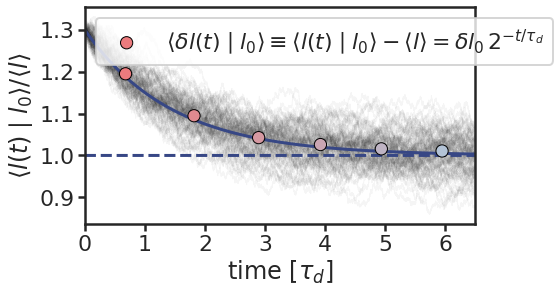

In [12]:
sns.set(style="white")
sns.set_context("poster")

dt = 1/data_frame.iloc[0]['doubling_rate']
string_list = make_list_of_strings_from_a_to_b(0, 99)
cpal = sns.color_palette("mycolormap", n_colors=list_length)

fig, ax = plt.subplots(figsize=(7,4))
df_lipids.plot(x='time', y=string_list, color='black', alpha=0.04, linewidth=1, legend=False, ax=ax)
df_lipids.plot(x='time', y='theory', color=blue, alpha=1, linewidth=3,  ax=ax, legend=False)
df_lipids.plot(x='time', y='steady_state', color=blue,  linewidth=3,  ax=ax, linestyle='--', legend=False)
df_lipid_conc_init.plot.scatter(x='t_init', y='mean', c=cpal, s=150,  ax=ax, edgecolors='black', 
                                linewidth = 1,
                                zorder=10,
                               label=r'$\langle \delta l(t) \mid l_0 \rangle \equiv \langle l(t) \mid l_0 \rangle-\langle l \rangle = \delta l_0 \, 2^{-t/\tau_d}$')
# label=r'$\langle l(t^\ast \mid l_0) \rangle/ \langle l \rangle$', 
ax.set(xlabel=r'time [$\tau_d$]', ylabel=r'$ \langle l(t) \mid l_0 \rangle / \langle l \rangle$')
# ax.set(ylim=(0.4,1.6))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_xticks([0, dt, 2*dt, 3*dt, 4*dt, 5*dt,  6*dt])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6'])
ax.tick_params(bottom=True, labelbottom=True)
ax.tick_params(which='major', length=7)
ax.tick_params(left=True, labelleft=True)
ax.set_yticks([0.9,1,1.1, 1.2, 1.3])
ax.set_yticklabels([r'0.9', r'1.0', r'1.1', r'1.2', r'1.3'])
# ax.tick_params(axis='x', colors='black')
ax.margins(x=0)
plt.savefig(file_path + '/lipid_conc_relax.pdf', format='pdf', bbox_inches='tight')

# Make data frame of initiation volume

## Theoretical initiation volume 

In [13]:
def return_array_of_v_init(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori']

In [14]:
def calculate_v_init(df, production_rate_lipids):
    return df.destruction_rate_datA / production_rate_lipids * df.frac_init * \
           (df.michaelis_const_prod + (1 - df.frac_init) * df.total_conc) / \
           ((1 - df.frac_init) * (df.michaelis_const_destr + df.frac_init * df.total_conc))-((df.production_rate_dars1+ df.production_rate_dars2)/production_rate_lipids)

df_v_init = pd.DataFrame()
for index, row in data_frame.iterrows():
    v_init_list = list(return_array_of_v_init(row.path_dataset))
#     print(v_init_list)
    df_v_init[str(index)] = v_init_list[:list_length]
df_v_init["mean"] = df_v_init.mean(axis=1)
df_v_init["generation"] = np.arange(0, list_length)

df_v_init["steady_state_v_init_th"] = calculate_v_init(data_frame.iloc[0], 
                                             data_frame["production_rate_lipids"][0] / data_frame["rate_growth"][0])
df_v_init["steady_state_lipids"] = data_frame["production_rate_lipids"][0] / data_frame["rate_growth"][0]
df_v_init["mean_v_init"] = 0.2913334422789667

## Find lipid conc at first initiation volume

In [15]:
df_v_init["theory_lipids"] =(df_v_init["steady_state_lipids"] + (mean_lipid_conc_0- df_v_init["steady_state_lipids"]) /(2**df_v_init["generation"]))

df_v_init["theory_v_init_1"] =  calculate_v_init(data_frame.iloc[0], 
                                             df_v_init["theory_lipids"] )
df_v_init["theory_v_init_2"] =  calculate_v_init(data_frame.iloc[0], 
                                             df_lipid_conc_init["mean"] )

df_v_init["adder"] = (df_v_init["mean"][0]- df_v_init["mean_v_init"])/(2**(df_v_init["generation"]))+ df_v_init["mean_v_init"]

## Plot initiation volume over generations

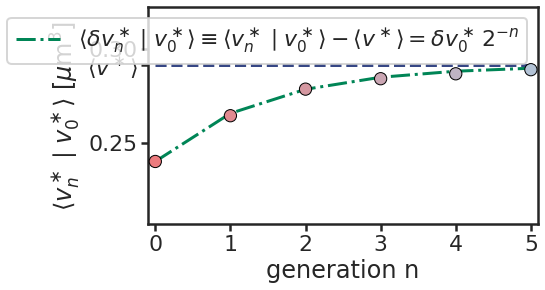

In [16]:
sns.set(style="white")
sns.set_context("poster")

dt = 1/data_frame.iloc[0]['doubling_rate']
string_list = make_list_of_strings_from_a_to_b(0, 99)
string_list = make_list_of_strings_from_a_to_b(0, 99)
cpal = sns.color_palette("mycolormap", n_colors=list_length)

fig, ax = plt.subplots(figsize=(7,4))
# df_v_init.plot(x='generation', y=string_list, color='black', alpha=0.05, linewidth=2, legend=False, ax=ax)
df_v_init.plot.scatter(x='generation', y='mean', color=cpal, alpha=1, linewidth=1,  ax=ax, 
                       s=150,  edgecolors='black', zorder=10)
# df_v_init.plot(x='generation', y='theory_v_init_1', color=blue, alpha=1, linewidth=3,  ax=ax, 
#                label=r'$v^\ast_{\rm th}$ using $l_{\rm th}$')
# df_v_init.plot(x='generation', y='theory_v_init_2', color='red', alpha=1, linewidth=3,  ax=ax, 
#                label=r'$v^\ast_{\rm th}$ using $\langle l \rangle$')
df_v_init.plot(x='generation', y='mean_v_init', color=blue,  linewidth=3,  ax=ax, linestyle='--', legend=False)
df_v_init.plot(x='generation', y='adder', color=green, alpha=1,  ax=ax, linestyle='-.', label=r'$\langle \delta v^\ast_{n} \mid v^\ast_0 \rangle \equiv \langle v^\ast_n \mid v_0^\ast \rangle - \langle v^\ast \rangle = \delta v^\ast_0 \, 2^{-n}$')

ax.set(xlabel=r'generation n', ylabel=r'$\langle v^\ast_n \mid v_0^\ast \rangle$ [$\mu$m$^3$]')
ax.set(xlim=(-0.1,5.1))
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
ax.tick_params(bottom=True, labelbottom=True)
ax.tick_params(which='major', length=7)
ax.tick_params(left=True, labelleft=True)
ax.set_yticks([0.25,df_v_init["mean_v_init"][0], 0.30])
ax.set_yticklabels([r'0.25', r'$\langle v^\ast \rangle$', r'0.30'])
# ax.tick_params(axis='x', colors='black')
plt.savefig(file_path + '/v_init_relax.pdf', format='pdf', bbox_inches='tight')

# Plot functional dependence of initiation volume on lipid conc

In [17]:
df_lipid_conc_abs = pd.DataFrame()
for index, row in data_frame.iterrows():
    lipid_conc_init_list = list(return_array_of_lipid_conc_init(row.path_dataset))
#     print(lipid_conc_init_list)
    df_lipid_conc_abs[str(index)] = lipid_conc_init_list[:list_length]
df_lipid_conc_abs["mean"] = df_lipid_conc_abs.mean(axis=1)
df_lipid_conc_abs["generation"] = np.arange(0, list_length)
df_lipid_conc_abs

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,mean,generation
0,3340.167188,3373.735991,3230.018506,3254.794660,3194.232615,3478.920240,3223.423183,3201.622310,3371.286142,3345.414958,...,3276.024062,3324.027991,3349.965374,3218.319382,3210.581757,3311.611066,3292.313732,3310.964003,3292.338779,0
1,3025.411057,3173.859252,2922.574336,3118.775503,2674.683631,3184.327060,3115.374289,3131.499210,2932.801125,3021.101800,...,3030.085258,2838.890775,2921.613045,3038.686430,2758.825100,3104.068614,2947.049965,2848.466934,3016.236102,1
2,2884.777425,3036.532008,2818.409559,2992.762573,2760.610332,2894.158709,2932.287223,2911.713464,3032.475314,2878.865760,...,2924.715669,2713.524339,2897.637843,2870.165793,2616.451638,2908.192230,2820.509854,2917.111485,2872.185969,2
3,2848.498334,2882.400166,2978.470213,2895.421236,2734.006252,2906.431516,2943.938017,2785.688215,2667.422955,2827.919113,...,2795.975909,2504.600044,2743.001324,2889.019044,2720.315494,3031.216795,2900.089801,2759.118664,2826.593969,3
4,2702.207332,2858.320363,2896.236385,2684.921354,2852.816225,2893.872339,2748.806458,2731.356999,2723.984285,2755.107480,...,2753.488579,2754.687952,2775.748027,2869.096611,2729.879704,3110.961253,2697.800070,2913.875580,2798.384314,4
5,2880.148776,2913.841557,2798.026878,2640.687671,2801.760897,2962.787803,2742.316207,2707.749601,2816.216783,2626.922844,...,2815.886096,2877.906164,2828.200468,3071.211393,2735.200394,2914.303282,2595.526342,2822.154309,2784.292000,5


In [18]:
def calculate_v_init_LDDR(df, production_rate_lipids):
    return df.destruction_rate_datA / production_rate_lipids * df.frac_init * \
           (df.michaelis_const_prod + (1 - df.frac_init) * df.total_conc) / \
           ((1 - df.frac_init) * (df.michaelis_const_destr + df.frac_init * df.total_conc))-((df.production_rate_dars1+ df.production_rate_dars2)/df.production_rate_lipids)

lipid_conc_average = data_frame['production_rate_lipids'][0] / data_frame['rate_growth'][0]
lipid_conc_arr = np.arange(0.935* lipid_conc_average, 1.3* lipid_conc_average, 5)
lipid_conc_init = calculate_v_init_LDDR(data_frame.iloc[0], df_lipid_conc_abs["mean"])
v_init_arr = calculate_v_init_LDDR(data_frame.iloc[0], lipid_conc_arr)
# print(v_init_arr)

6


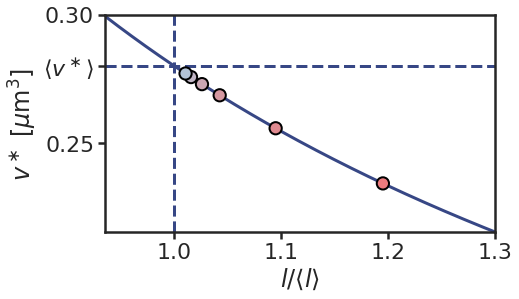

In [19]:
sns.set(style="white")
sns.set_context("poster")
print(len(cpal))
lipid_conc_average = data_frame['production_rate_lipids'][0] / data_frame['rate_growth'][0]
lipid_conc_0 = data_frame['lipid_conc_0'][0]
v_init_average = calculate_v_init_LDDR(data_frame.iloc[0], 
                                       data_frame['production_rate_lipids'][0] / data_frame['rate_growth'][0])
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(lipid_conc_arr, v_init_arr, color=blue)
plt.scatter(df_lipid_conc_abs["mean"], lipid_conc_init, color=cpal,  s=150,  edgecolors='black', zorder=10)
# ax.plot(x='generation', y='mean',  alpha=1, linewidth=1,  ax=ax, label=r'$\langle v^\ast \rangle$', s=150,  edgecolors='black')
ax.axvline(lipid_conc_average, linestyle='--', linewidth=3, color=blue)
ax.axhline(v_init_average,
           linestyle='--', linewidth=3, color=blue)
ax.margins(0)
ax.set(xlim=(np.min(lipid_conc_arr), np.max(lipid_conc_arr)))
# ax.set_xticks([lipid_conc_average])
# ax.set_xticklabels([r'$\langle l \rangle$'])
ax.set_xticks([1* lipid_conc_average, 1.1* lipid_conc_average,1.2* lipid_conc_average,1.3* lipid_conc_average])
ax.set_xticklabels([r'1.0', r'1.1', r'1.2', r'1.3'])
ax.tick_params(bottom=True, labelbottom=True)
ax.tick_params(left=True, labelleft=True)
ax.tick_params(which='major', length=7)
ax.set_yticks([ 0.25,df_v_init["steady_state_v_init_th"][0], 0.30])
ax.set_yticklabels([ r'0.25', r'$\langle v^\ast \rangle$', r'0.30'])
ax.set(xlabel=r'$l / \langle l \rangle$', ylabel=r'$v^\ast$ [$\mu$m$^3$]')
# plt.legend()
plt.savefig(file_path + '/mapping.pdf', format='pdf', bbox_inches='tight')